<a href="https://colab.research.google.com/github/EdgarGM20/ML-NLP/blob/main/S1TC1_arboles_ensamblajes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

**Preview**

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

**Data Fields**

datetime - hourly date + timestamp

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated
count - number of total rentals


### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

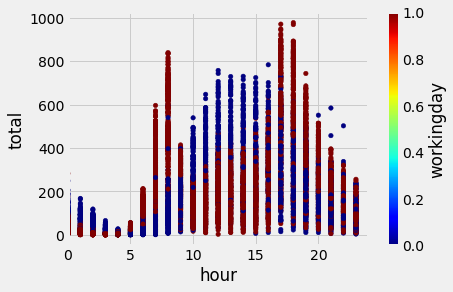

In [6]:
# Gráfica del total, hora y workingday
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
bikes.plot(kind='scatter', x='hour', y='total', c='workingday', colormap='jet', xlim=(0, 24)) #, ylim=(0, 250)

In [7]:
# Descripción de la variable de respuesta 'total'
bikes.total.describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: total, dtype: float64

**Conclusiones:**

*   En promedio, se rentan 191 bicicletas al día, teniendo picos en el que mínimo solo rentan 1 y máximo 977, sin embargo, este último es un valor atípico ya que 75% de la distribución está por debajo de las 284 bicicletas rentadas.
*   Los días festivos tienen en promedio rentan 5 bicicletas más que en los días festivos
*   En general, los picos de demanda de bicicletas en el día son a las 8 AM y a las 5 PM

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

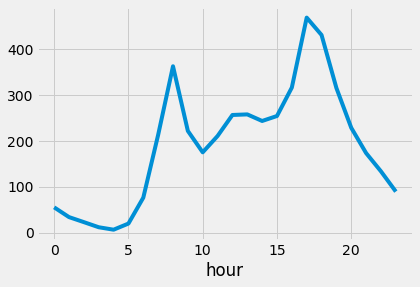

In [8]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

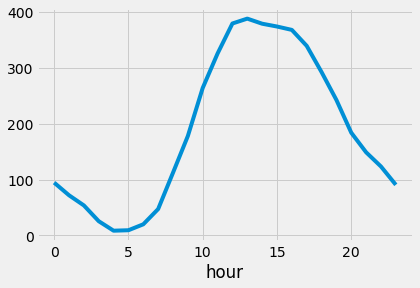

In [9]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
bikes[bikes['workingday']==0].groupby('hour').total.mean().plot()

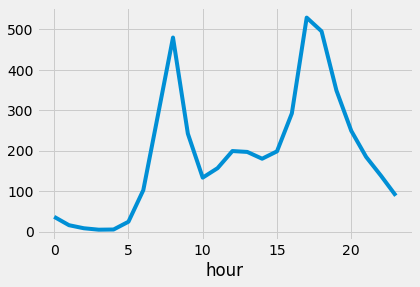

In [10]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
bikes[bikes['workingday']==1].groupby('hour').total.mean().plot()

**Conclusiones**
* Celda 2.2 - Al discriminar por tipo de día (laboral o festivo) se observa que para en los días festivos hay un pico de rentas de bicicletas entre las 11AM y las 3PM
* Celda 2.3 - Por otro lado, en los días laborales, hay dos picos de rentas de bicicletas que son a las 8 AM y a las 5 PM

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [11]:
# Celda 3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt

data = bikes.reset_index().drop(columns=['datetime']).copy()
XTotal = data[['hour', 'workingday']]
yTotal = data['total']
#XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.33, random_state=0)
XTrain = XTotal
XTest = XTotal
yTrain = yTotal
yTest = yTotal


# Modelo con penalización tipo ElasticNET
n_alphas = 200
alphasCalibrar = np.logspace(-10, 2, n_alphas)
modeloElastic = ElasticNetCV(alphas=alphasCalibrar,cv=5, random_state=0).fit(XTrain,yTrain)
        
print('ELASTIC NET penalty\n') 
print('El parámetro de penalización es:')
print(modeloElastic.alpha_)
print('El valor del R^2 es:')
print(modeloElastic.score(XTrain, yTrain))
print('Los coeficientes estimados son:')
print(modeloElastic.coef_)
        
prediccionElastic=modeloElastic.predict(XTest)
MSEElastic=np.average(np.square(prediccionElastic-yTest))
print('MSE regresión con penalización tipo Elastic Net:')
print(MSEElastic)

ELASTIC NET penalty

El parámetro de penalización es:
3.5707859649004554
El valor del R^2 es:
0.16023195740833762
Los coeficientes estimados son:
[10.07921408  0.        ]
MSE regresión con penalización tipo Elastic Net:
27553.04047254037


**Conclusión**

Al ajustar un modelo de regresión lineal ElasticNET se observa una relación positiva con la variable hora del día en la que por cada aumento de una hora conlleva a que aumente el número de bicicletas rentadas por un factor de 10. Adicionalmente, no se observa una relación entre el tipo de día y el número de bicicletas rentadas. Sin embargo, el valor del coeficiente de determinación  r2 es de 0.16. Esto indica que la regresión lineal no es el modelo que mejor se ajusta a este conjunto de datos  

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [12]:
# Celda 4
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
#j, split, gain = best_split(XTotal, yTotal, 5)
#j, split, gain

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

# Aplicación de la función tree_grow
tree = tree_grow(XTotal, yTotal, level=0, min_gain=0.001, max_depth=6, num_pct=10)
print(tree)

# Ejecución de función tree_predict
y_pred = tree_predict(XTest, tree, True)
MSEDT = np.average(np.square(y_pred - yTotal))
print('MSE regresión con DT:')
print(MSEDT)

print(tree['level'])

{'y_pred': 1, 'y_prob': 191.53903379867745, 'level': 0, 'split': [0, 8.0], 'n_samples': 10886, 'gain': 18268.811823533004, 'sl': {'y_pred': 1, 'y_prob': 55.40711902113459, 'level': 1, 'split': [0, 7.0], 'n_samples': 3594, 'gain': 7207.700659959655, 'sl': {'y_pred': 1, 'y_prob': 32.561604584527224, 'level': 2, 'split': [0, 6.0], 'n_samples': 3139, 'gain': 646.8008927589567, 'sl': {'y_pred': 1, 'y_prob': 25.15934475055845, 'level': 3, 'split': [0, 2.0], 'n_samples': 2684, 'gain': 382.8088308604629, 'sl': {'y_pred': 1, 'y_prob': 44.41383095499451, 'level': 4, 'split': [1, 1.0], 'n_samples': 909, 'gain': 1402.5704281636313, 'sl': {'y_pred': 1, 'y_prob': 82.63356164383562, 'level': 5, 'split': [0, 1.0], 'n_samples': 290, 'gain': 254.91262782401645, 'sl': {'y_pred': 1, 'y_prob': 93.21088435374149, 'level': 6, 'split': -1, 'n_samples': 145, 'gain': 0}, 'sr': {'y_pred': 1, 'y_prob': 70.93877551020408, 'level': 6, 'split': -1, 'n_samples': 145, 'gain': 0}}, 'sr': {'y_pred': 1, 'y_prob': 26.3011

Rentas promedio por hora


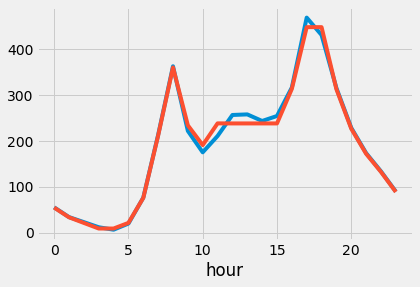

Rentas promedio por hora - work = 0


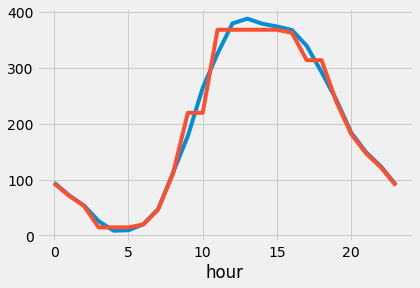

Rentas promedio por hora - work = 1


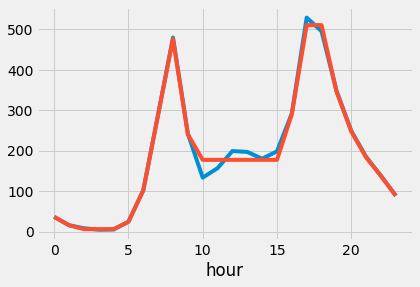

In [13]:
result = pd.concat([XTest, yTotal, pd.DataFrame(y_pred, columns=['y_pred'])], axis=1)

print('Rentas promedio por hora')
result.groupby('hour').total.mean().plot()
result.groupby('hour').y_pred.mean().plot()

plt.show()
print('Rentas promedio por hora - work = 0')
result[result['workingday']==0].groupby('hour').total.mean().plot()
result[result['workingday']==0].groupby('hour').y_pred.mean().plot()

plt.show()
print('Rentas promedio por hora - work = 1')
result[result['workingday']==1].groupby('hour').total.mean().plot()
result[result['workingday']==1].groupby('hour').y_pred.mean().plot()

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

Árbol con mejor desempeño: 
 (22567.73107684959, 1) 

MSE regresión con DT sklearn:
11329.31152387664


,feature,importance
1,workingday,0.186842
0,hour,0.813158


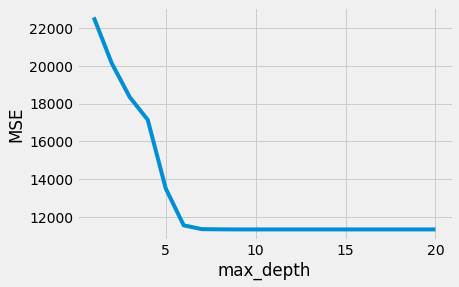

In [14]:
# Celda 5
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeRegressor de la libreria sklearn
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    clf.fit(XTrain, yTrain)
    accuracy_scores.append(np.average(np.square(clf.predict(XTest) - yTotal)))

# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('MSE')

# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
print("Árbol con mejor desempeño: \n", sorted(zip(accuracy_scores, max_depth_range))[::-1][0],"\n")

# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 
clf_best = DecisionTreeRegressor(max_depth=6, random_state=1)
clf_best.fit(XTrain, yTrain)

MSEDT_sk = np.average(np.square(clf.predict(XTest) - yTotal))
print('MSE regresión con DT sklearn:')
print(MSEDT_sk)

# Uso de la función .feature_importances_ para obtener la importancia de cada variable
pd.DataFrame({'feature':['hour', 'workingday'], 'importance':clf_best.feature_importances_}).sort_values('importance')

**Conclusión**

Al comparar el desempeño obtenido en los puntos  4 y 5 se observa que los árboles de decisión tienen un mejor modelo en comparación que la regresión lineal ya que la métrica de comparación, el MSE, pasa de 27553 a 11329. Por otro lado, gráficamente en el punto 4, se puede observar que el comportamiento de los resultados predichos se asemenjan bastante a los resultados reales

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

**Attribute Information:**

Number of Attributes: 61 (58 predictive attributes, 2 non-predictive, 1 goal field)

Attribute Information:
0. url: URL of the article (non-predictive)
1. timedelta: Days between the article publication and the dataset acquisition (non-predictive)
2. n_tokens_title: Number of words in the title
3. n_tokens_content: Number of words in the content
4. n_unique_tokens: Rate of unique words in the content
5. n_non_stop_words: Rate of non-stop words in the content
6. n_non_stop_unique_tokens: Rate of unique non-stop words in the content
7. num_hrefs: Number of links
8. num_self_hrefs: Number of links to other articles published by Mashable
9. num_imgs: Number of images
10. num_videos: Number of videos
11. average_token_length: Average length of the words in the content
12. num_keywords: Number of keywords in the metadata
13. data_channel_is_lifestyle: Is data channel 'Lifestyle'?
14. data_channel_is_entertainment: Is data channel 'Entertainment'?
15. data_channel_is_bus: Is data channel 'Business'?
16. data_channel_is_socmed: Is data channel 'Social Media'?
17. data_channel_is_tech: Is data channel 'Tech'?
18. data_channel_is_world: Is data channel 'World'?
19. kw_min_min: Worst keyword (min. shares)
20. kw_max_min: Worst keyword (max. shares)
21. kw_avg_min: Worst keyword (avg. shares)
22. kw_min_max: Best keyword (min. shares)
23. kw_max_max: Best keyword (max. shares)
24. kw_avg_max: Best keyword (avg. shares)
25. kw_min_avg: Avg. keyword (min. shares)
26. kw_max_avg: Avg. keyword (max. shares)
27. kw_avg_avg: Avg. keyword (avg. shares)
28. self_reference_min_shares: Min. shares of referenced articles in Mashable
29. self_reference_max_shares: Max. shares of referenced articles in Mashable
30. self_reference_avg_sharess: Avg. shares of referenced articles in Mashable
31. weekday_is_monday: Was the article published on a Monday?
32. weekday_is_tuesday: Was the article published on a Tuesday?
33. weekday_is_wednesday: Was the article published on a Wednesday?
34. weekday_is_thursday: Was the article published on a Thursday?
35. weekday_is_friday: Was the article published on a Friday?
36. weekday_is_saturday: Was the article published on a Saturday?
37. weekday_is_sunday: Was the article published on a Sunday?
38. is_weekend: Was the article published on the weekend?
39. LDA_00: Closeness to LDA topic 0
40. LDA_01: Closeness to LDA topic 1
41. LDA_02: Closeness to LDA topic 2
42. LDA_03: Closeness to LDA topic 3
43. LDA_04: Closeness to LDA topic 4
44. global_subjectivity: Text subjectivity
45. global_sentiment_polarity: Text sentiment polarity
46. global_rate_positive_words: Rate of positive words in the content
47. global_rate_negative_words: Rate of negative words in the content
48. rate_positive_words: Rate of positive words among non-neutral tokens
49. rate_negative_words: Rate of negative words among non-neutral tokens
50. avg_positive_polarity: Avg. polarity of positive words
51. min_positive_polarity: Min. polarity of positive words
52. max_positive_polarity: Max. polarity of positive words
53. avg_negative_polarity: Avg. polarity of negative words
54. min_negative_polarity: Min. polarity of negative words
55. max_negative_polarity: Max. polarity of negative words
56. title_subjectivity: Title subjectivity
57. title_sentiment_polarity: Title polarity
58. abs_title_subjectivity: Absolute subjectivity level
59. abs_title_sentiment_polarity: Absolute polarity level
60. shares: Number of shares (target)

### Datos popularidad de noticias

In [15]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [16]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [17]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

logreg
accuracy_score: 0.6212121212121212
f1_score: 0.6073298429319371
confusion_matrix: 
 [[650 411]
 [339 580]] 

dtc
accuracy_score: 0.6429292929292929
f1_score: 0.637249871729092
confusion_matrix: 
 [[652 370]
 [337 621]] 

Mejor modelo: 
 (Accuracy, max_depth):  (0.6263681592039801, 1) 

max_depth versus Accuracy: 



Text(0, 0.5, 'Accuracy')

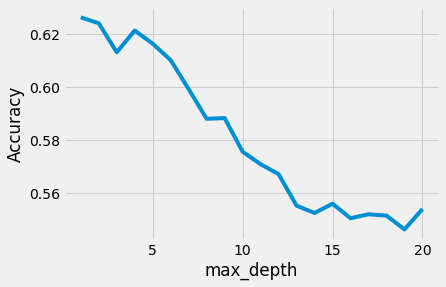

In [18]:
# Celda 6
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Calibración del arbol de decisión
def calibración_dt(X, y):
  # Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
  max_depth_range = range(1, 21)

  # Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
  accuracy_scores = []

  # Importación de modelos de sklearn 
  from sklearn.model_selection import cross_val_score
  from sklearn.tree import DecisionTreeClassifier

  # Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
  for depth in max_depth_range:
      # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
      clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
      accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

  
  return max_depth_range, accuracy_scores, max_depth_range

cal_dt = calibración_dt(X_train, y_train)

###############################################################################
# Definición de 2 modelos diferentes: regresión logística, árbol de decisión de clasificación
n_features = len(X_train)
models = {'logreg': LogisticRegression(),
          'dtc': DecisionTreeClassifier(max_depth=1)}

# Entrenamiento (fit) de cada modelo
for model in models.keys():
    models[model].fit(X_train, y_train)

# Predicción de las observaciones del set de test para cada modelo
y_pred = pd.DataFrame(index=X_test.index, columns=models.keys())
for model in models.keys():
    y_pred[model] = models[model].predict(X_test)

acc_1dt = accuracy_score(y_pred['dtc'], y_test)
acc_1lr = accuracy_score(y_pred['logreg'], y_test)

# Evaluación del error de cada modelo


for model in models.keys():
    print(model)
    print("accuracy_score:",  accuracy_score(y_pred[model], y_test))
    print("f1_score:", f1_score(y_pred[model], y_test))
    print("confusion_matrix: \n", confusion_matrix(y_pred[model], y_test), "\n")

# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
print("Mejor modelo: \n", "(Accuracy, max_depth): ", sorted(zip(cal_dt[1],cal_dt[2]))[::-1][0], "\n")



# Gráfica max_depth versus RMSE (error del modelo)
print("max_depth versus Accuracy: \n")
plt.show()
plt.plot(cal_dt[0], cal_dt[1])
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [19]:
# Celda 7
# Definición del modelo BaggingClassifier de la libreria sklearn
from sklearn.ensemble import BaggingClassifier
clf_1 = BaggingClassifier(base_estimator= DecisionTreeClassifier(max_depth = None), max_samples=300, n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)
clf_2 = BaggingClassifier(base_estimator= DecisionTreeClassifier(max_depth = 2), max_samples=300, n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)
clf_3 = BaggingClassifier(base_estimator= LogisticRegression(), max_samples=300, n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf_1.fit(X_train, y_train)
y_pred_1 = clf_1.predict(X_test)

clf_2.fit(X_train, y_train)
y_pred_2 = clf_2.predict(X_test)

clf_3.fit(X_train, y_train)
y_pred_3 = clf_3.predict(X_test)

print("Modelo 1:\n")
acc_1vm = accuracy_score(y_pred_1, y_test)
print("accuracy_score:", acc_1vm)
print("f1_score:", f1_score(y_pred_1, y_test))
print("confusion_matrix: \n", confusion_matrix(y_pred_1, y_test), "\n")

print("Modelo 2:\n")
acc_2vm = accuracy_score(y_pred_2, y_test)
print("accuracy_score:", acc_2vm)
print("f1_score:", f1_score(y_pred_2, y_test))
print("confusion_matrix: \n", confusion_matrix(y_pred_2, y_test), "\n")

print("Modelo 3:\n")
acc_3vm = accuracy_score(y_pred_3, y_test)
print("accuracy_score:", acc_3vm)
print("f1_score:", f1_score(y_pred_3, y_test))
print("confusion_matrix: \n", confusion_matrix(y_pred_3, y_test), "\n")

# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(3)))
y_pred_df.iloc[:, 0] = y_pred_1
y_pred_df.iloc[:, 1] = y_pred_2
y_pred_df.iloc[:, 2] = y_pred_3
#y_pred_df.head()

# Votación mayoritaria
y_pred_4 = (y_pred_df.sum(axis=1) >= (3 / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
print("Modelo 4:\n")
print("accuracy_score:",  accuracy_score(y_pred_4, y_test))
print("f1_score:", f1_score(y_pred_4, y_test))
print("confusion_matrix: \n", confusion_matrix(y_pred_4, y_test), "\n")


Modelo 1:

accuracy_score: 0.6590909090909091
f1_score: 0.6599496221662469
confusion_matrix: 
 [[650 336]
 [339 655]] 

Modelo 2:

accuracy_score: 0.6525252525252525
f1_score: 0.6405433646812958
confusion_matrix: 
 [[679 378]
 [310 613]] 

Modelo 3:

accuracy_score: 0.6212121212121212
f1_score: 0.6027542372881356
confusion_matrix: 
 [[661 422]
 [328 569]] 

Modelo 4:

accuracy_score: 0.6555555555555556
f1_score: 0.6444212721584983
confusion_matrix: 
 [[680 373]
 [309 618]] 



### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [20]:
# Celda 8

def vot_pond(clf_, X_train, y_train, X_test, y_test):
  # Ajuste del modelo
  clf_.fit(X_train, y_train)
  # Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
  errors_1 = np.zeros(clf_.n_estimators)
  y_pred_all_1 = np.zeros((X_test.shape[0], clf_.n_estimators))

  for i in range(clf_.n_estimators):
    oob_sample = ~clf_.estimators_samples_[i]
    y_pred_ = clf_.estimators_[i].predict(X_train.values[oob_sample])
    errors_1[i] = accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_1[:, i] = clf_.estimators_[i].predict(X_test)
      
  alpha_1 = (1 - errors_1) / (1 - errors_1).sum()
  y_pred_1_ = (np.sum(y_pred_all_1 * alpha_1, axis=1) >= 0.5).astype(np.int)

  # Desempeño al hacer votación ponderada
  acc_ = accuracy_score(y_pred_1_, y_test)
  print("accuracy_score:",  accuracy_score(y_pred_1_, y_test))
  print("f1_score:", f1_score(y_pred_1_, y_test))
  print("confusion_matrix: \n", confusion_matrix(y_pred_1_, y_test), "\n")

  return acc_
# Definición del modelo BaggingClassifier de la libreria sklearn

clf_1vp = BaggingClassifier(base_estimator= DecisionTreeClassifier(max_depth = None), max_samples=300, n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)
clf_2vp = BaggingClassifier(base_estimator= DecisionTreeClassifier(max_depth = 2), max_samples=300, n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)
clf_3vp = BaggingClassifier(base_estimator= LogisticRegression(), max_samples=300, n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)


print("Modelo 1:\n")
acc_1vp = vot_pond(clf_1vp, X_train, y_train, X_test, y_test)

print("Modelo 2:\n")
acc_2vp = vot_pond(clf_2vp, X_train, y_train, X_test, y_test)

print("Modelo 3:\n")
acc_3vp = vot_pond(clf_3vp, X_train, y_train, X_test, y_test)

Modelo 1:

accuracy_score: 0.6611111111111111
f1_score: 0.6646676661669165
confusion_matrix: 
 [[644 326]
 [345 665]] 

Modelo 2:

accuracy_score: 0.648989898989899
f1_score: 0.6344029458179905
confusion_matrix: 
 [[682 388]
 [307 603]] 

Modelo 3:

accuracy_score: 0.6222222222222222
f1_score: 0.6008537886873
confusion_matrix: 
 [[669 428]
 [320 563]] 



### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

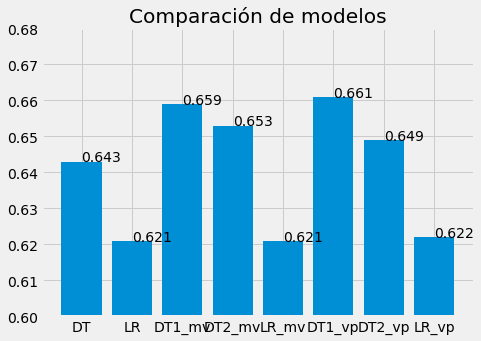

In [21]:
# Celda 9

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['DT','LR', 'DT1_mv', 'DT2_mv','LR_mv','DT1_vp', 'DT2_vp','LR_vp']
n_dec = 3
ejeY = [np.round(acc_1dt,n_dec), np.round(acc_1lr,n_dec), np.round(acc_1vm,n_dec), np.round(acc_2vm,n_dec), np.round(acc_3vm,n_dec), np.round(acc_1vp,n_dec), np.round(acc_2vp,n_dec), np.round(acc_3vp,n_dec)]
ax.bar(ejeX, ejeY)
def addlabels(x,y,plotP):
    for i in range(len(ejeX)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
#plt.yticks([0.5, 0.7])
plt.ylim(0.6, 0.68)
plt.show()


**Conclusión**

Al comparar los 8 modelos generados, los dos primeros (DT y LR) sin estrategias de bagging, los tres siguientes con estrategias de bagging por votación mayoritaria (_mv) y los tres últimos con estrategias de bagging por votación ponderada (_vp) se encuentra que el mejor resultado se da ligeramente por la estrategia de votación ponderada con árboles de decisión sin restricción de máxima profundidad con un accuracy de 0.661. Sin embargo, se evidencia que la diferencia no es tan alta (0.002) al compararla con la estrategia de votación mayoritaria del mismo modelo, por lo que en este caso, las dos estrategias producen resultados similares. Por lo tanto:
* La ventaja de usar estrategias de ensamble es que permite mejorar algunos puntos porcentuales el desempeño de un clasificador y que robustece el modelo al disminuir su varianza 
* Como desventaja se tiene que el ensamblaje es altamente dependiente del modelo que se seleccione y que aumenta la carga computacional ya que se debe entrenar n-modelos para escoger la mejor respuesta por consenso.